Work in progress - Note to myself, still to do:
    - test error calculation on X_train vs full X
    - implement a better way for feature reduction (Lasso or backward approach from ML-Statistics book)
    - write background info on evaluation scores
    

**Note:** If the data is already centered and you want `fit_intercept = False`, then normalization will not be applied. See [here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) for more info, and see Bycicle notebook for an example with centered data.

# Demo of LinRegModel Class and it's Methods

### Load libraries and data

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import resample  # will be used for error calculation on feature weights

import EDA_functions, cleaning_functions
from linRegModel_class import LinRegModel

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

# display all columns in df
from IPython.display import display
pd.options.display.max_columns = None

In [2]:
housing = pd.read_csv('../data/housing.csv')

### Check dataframe structure

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing.sample(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
2694,-115.40,32.86,19.0,1087.0,171.0,649.0,173.0,3.3182,113800.0,INLAND
14502,-117.23,32.87,11.0,3123.0,740.0,1223.0,634.0,5.4170,196800.0,NEAR OCEAN
13619,-117.25,34.13,35.0,861.0,148.0,381.0,138.0,2.5234,88200.0,INLAND


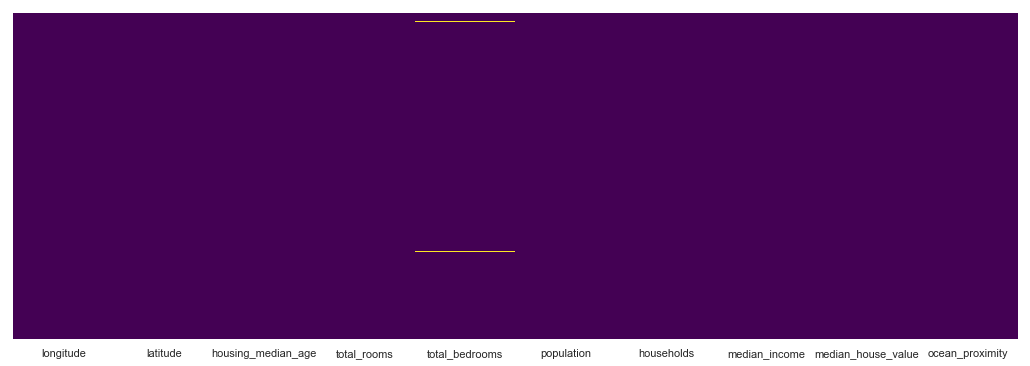

In [5]:
cleaning_functions.plot_NaN(housing)

In [6]:
cleaning_functions.list_NaN(housing)

Number of NaN per column:
total_bedrooms: 207 (0.01%)


## Initialize Your Model

First step is to initialize a (or a couple of different) linear scikit-learn model object with it's correspoding parameters. 

In [7]:
# define a scikit-learn model object you want to work with
model = LinearRegression(normalize=True)
# create an instance of the LinRegModel class by passing the dataframe, the target variable and the model object
linReg_simple = LinRegModel(housing, 'median_house_value', model)

In [8]:
# you can output the model with help of the instance variable name
linReg_simple

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

### General back-ground information to help with choosing models

**Typical models to work with**:
- **Linear Regression / Ordinary Least Squares** is an unregularized, 'simple' Linear Regression. Important parameters are `fit_intercept` and / or `normalize`. (More on the different parameters below.)
- **Lasso Regression / L1** produces sparse solutions and as such is useful _selecting a strong subset of features_ for improving model performance. But it's result can be very unstable. Additional important parameter is `alpha`, the regularization strength.  
- **Ridge Regression / L2** on the other hand can be used for _data interpretation_ due to its stability and the fact that useful features tend to have non-zero coefficients. Same important parameters as above.
- **Elastic Net** is a middle ground between Lasso and Ridge. The regularization term is a simple mix of both's regularization terms. The parameter in charge of the mix is `l1_ratio`: 0 is equivalent to Ridge Regression, 1 is equivalent to Lasso Regression.

__Explanation__: Generally in linear regression only the _residual sum of squares (RSS)_ is minimized, whereas in ridge and lasso regression, a _penalty is applied on coefficient values_ with the tuning parameter lambda (lambda=0 no penalty effect, lambda=large pushes coefficients towards / to zero).

- _L2 / Ridge_ shrinks the weights according to their importance, but does not set them exactly to zero in order to eliminate unneccessary predictors from models. It will always include all the predictors. _Models from Ridge provide accuracy but are hard to interpret when the numer of predictors is large._
- _L1 / Lasso_ on the other hand sets the weights of the unnecessary variables to zero and so eliminates them creating compact models that are easier to interpret. _Models from lasso are very much like subset selection_. The cost is less robustness.


__Which ones to use__: Generally it is always preferable to have at least a little bit of regularization (so avoid plain Linear Regression)*. _Ridge is a good default_ - but if you suspect that only a few features are actually useful, you should prefer Lasso or Elastic Net since they tend to reduce the useless features' weights down to zero. In general, Elastic Net is preferred over Lasso since the latter may behave erratically when the number of features is greater than the number of training instances or when several features are strongly correlated. 

In any case: use the RidgeCV / LassoCV / ElasticNetCV variants to find the right alpha / l1_ratio settings!

*Note if you set parameter `normalize=True` for a LinearRegression you have some L2-Regularization (see below).


**Parameters** (as described on the sk-learn website):
- `fit_intercept` (boolean, optional, default True): Parameter whether to calculate the intercept for this model. If set to False, no intercept will be used in calculations (e.g. data is expected to be already centered).
- `normalize` (boolean, optional, default False): This parameter is ignored when fit_intercept is set to False. If True, the regressors X will be normalized before regression by subtracting the mean and dividing by the l2-norm. (Note: If you wish to standardize, please use sklearn.preprocessing.StandardScaler before calling fit on an estimator with normalize=False.)
- `alpha` ({float, array-like}, shape (n_targets)): Regularization strength; must be a positive float. Regularization improves the conditioning of the problem and reduces the variance of the estimates. Larger values specify stronger regularization. Alpha corresponds to C^-1 in other linear models such as LogisticRegression or LinearSVC. If an array is passed, penalties are assumed to be specific to the targets. Hence they must correspond in number.
- `l1_ratio` (float): The ElasticNet mixing parameter, with 0 <= l1_ratio <= 1. For l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty. For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.


**Further reading**:
- _Scikit-learn_ [documentation](https://scikit-learn.org/stable/modules/linear_model.html)
- _Hands-On Machine Learning with Scikit-Learn and TensorFlow_ by Aurèlien Géron. (O'Reilly)
- _Pyhton Data Science Handbook_ by Jake Vanderplas (O'Reilly)
- This interesting [blog post on "Diving Into Data"](http://blog.datadive.net/selecting-good-features-part-ii-linear-models-and-regularization/) by Ando Saabas

## Use the function `go_quickDirty` for one-step linear regression modelling

`go_quickDirty` is a method of the LinRegModel class for preprocessing data, fitting and testing a linear regression model _in one step_. You can pass (almost) any unprepared data. (It is called quick & dirty because the preprocessing is quite unsophisticated: NA values will be  handled in a simple way, categorical variables dummied. But there is no outlier treatment or scaling. So you better make sure to set the parameter 'normalize=True' for your model input.)

Details on preprocessing:
- All columns with dtype object and category will be one-hot-encoded. (Make sure they all have categorical character.)
- All NaN in numerical cols will be imputed with mean, all NaN in non-numerical columns will be dummied (for mixing into the zero category, change the 'dummy_na' parameter)

In [9]:
# perform linear regression modelling on instance
linReg_simple.go_quickDirty()

In [10]:
# after modelling you can ouptut the RMSE and the r2-Score with help of the instance variable name
linReg_simple

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

RMSE on test data 69674.27, r2-score 0.63.

### Background infrmation on evaluation scores
- RMSE has to be calculated from MSE. Both are sensitive to outliers. If you have lot's of outliers MAE might be preferable.
- R2-score can be problematic, there is also an adjusted R2-score to consider.

## Evaluate the model

[learning_curve] Training set sizes: [  115   717  1320  1922  2524  3126  3728  4331  4933  5535  6137  6740
  7342  7944  8546  9149  9751 10353 10955 11558]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished


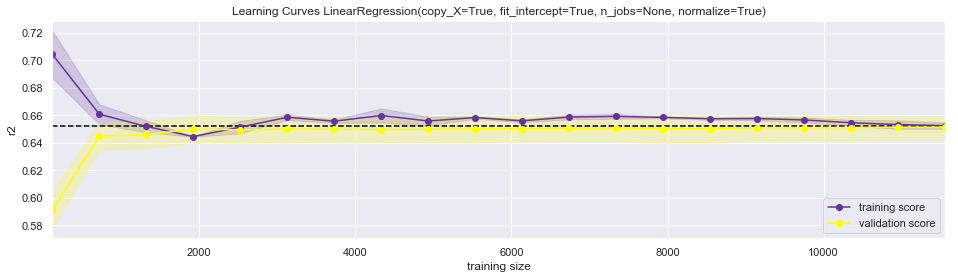

In [11]:
# plot learning curves using 5-fold cross validation
linReg_simple.plot_learning_curves()

In [12]:
# plot feature weights (error estimation by bootstrapping)
linReg_simple.print_coef_weights(n_bootstrap=1000)

,effect,error
ocean_proximity_ISLAND,216162.0,1080.0
ocean_proximity_INLAND,-40453.2,1059.0
median_income,38622.0,59.0
longitude,-26176.7,1.0
latitude,-24968.5,12.0
ocean_proximity_NEAR BAY,-4524.3,3.0
ocean_proximity_NEAR OCEAN,2576.4,13.0
housing_median_age,1074.0,599.0
households,94.5,1739.0
total_bedrooms,64.8,36726.0


**Interpretation:** The default penalty on coefficients using linear regression in sklearn is a ridge (also known as an L2) penalty.  Because of this penalty, and because all the variables were normalized, we can look at the size of the coefficients in the model as an indication of the impact of each variable on the target variable. The larger the coefficient, the larger the expected impact. 

### Check results for Ridge, Lasso & ElasticNet


In [13]:
# define RidgeCV without normalization but higher alphas)
model = RidgeCV(alphas=[2000, 5000, 10000], cv=3, fit_intercept=True)
# instantiate
ridgeCV_simple = LinRegModel(housing, 'median_house_value', model)
# perform linear regression modelling
ridgeCV_simple.go_quickDirty()
# output scores
ridgeCV_simple

RidgeCV(alphas=array([ 2000,  5000, 10000]), cv=3, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

RMSE on test data 70262.77, r2-score 0.62.

In [14]:
# check best alpha value (has to be done with model)
model.alpha_

2000

In [15]:
# plot feature weights - for bigger data you should calculate them with the optimized model only
ridgeCV_simple.print_coef_weights(n_bootstrap=1000)

,effect,error
median_income,38479.1,464.0
ocean_proximity_INLAND,-25814.1,437.0
latitude,-21012.5,57.0
longitude,-20708.4,1.0
ocean_proximity_NEAR OCEAN,4918.5,10.0
ocean_proximity_NEAR BAY,2367.5,3.0
housing_median_age,1249.7,12.0
ocean_proximity_ISLAND,334.6,536.0
households,116.7,612.0
total_bedrooms,49.7,215.0


In [16]:
# define lassoCV without normalization (but higher alphas)
model = LassoCV(alphas=[2000, 5000, 10000],cv=3, fit_intercept=True)
# instantiate
lassoCV_simple = LinRegModel(housing, 'median_house_value', model)
# perform linear regression modelling
lassoCV_simple.go_quickDirty()
# output scores
lassoCV_simple

LassoCV(alphas=[2000, 5000, 10000], copy_X=True, cv=3, eps=0.001,
    fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=None,
    normalize=False, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

RMSE on test data 69953.42, r2-score 0.62.

In [17]:
model.alpha_

2000

In [18]:
# plot feature weights - for bigger data you should calculate them with the optimized model only
lassoCV_simple.print_coef_weights(n_bootstrap=1000)

,effect,error
median_income,39036.1,1005.0
ocean_proximity_INLAND,-36038.0,1009.0
longitude,-20268.9,59.0
latitude,-20000.1,1.0
housing_median_age,1171.6,11.0
households,108.6,3.0
total_bedrooms,57.8,12.0
population,-45.7,592.0
total_rooms,-4.4,1658.0
ocean_proximity_ISLAND,0.0,0.0


In [19]:
# define ElasticNetCV without normalization
model = ElasticNetCV(alphas=[0.5, 0.1, 1.5], copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=None, n_jobs=-1)
# instantiate
elasticNetCV_simple = LinRegModel(housing, 'median_house_value', model)
# perform linear regression modelling on instance
elasticNetCV_simple.go_quickDirty()
# output scores
elasticNetCV_simple

ElasticNetCV(alphas=[0.5, 0.1, 1.5], copy_X=True, cv=5, eps=0.001,
       fit_intercept=True, l1_ratio=0.5, max_iter=1000, n_alphas=None,
       n_jobs=-1, normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

RMSE on test data 69760.39, r2-score 0.63.

***

## Second approach with proper data preparation

In [20]:
housing = pd.read_csv('../data/housing.csv')

In [21]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


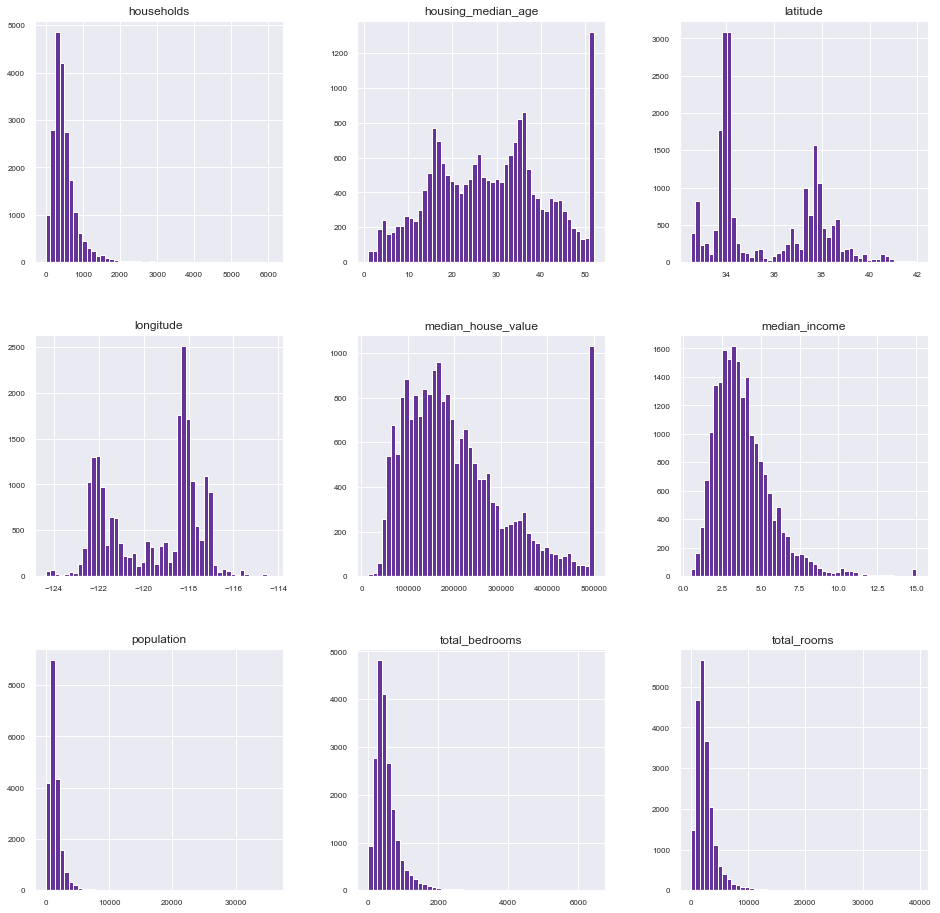

In [22]:
EDA_functions.plot_num_hist(housing)

In [23]:
cleaning_functions.count_outliers_IQR_method(housing, IQR_dist=2.5)

longitude
Identified outliers: 0
Percentage of outliers: 0.0%

latitude
Identified outliers: 0
Percentage of outliers: 0.0%

housing_median_age
Identified outliers: 0
Percentage of outliers: 0.0%

total_rooms
Identified outliers: 643
Percentage of outliers: 3.1%

total_bedrooms
Identified outliers: 626
Percentage of outliers: 3.0%

population
Identified outliers: 565
Percentage of outliers: 2.7%

households
Identified outliers: 601
Percentage of outliers: 2.9%

median_income
Identified outliers: 266
Percentage of outliers: 1.3%

median_house_value
Identified outliers: 0
Percentage of outliers: 0.0%



In [24]:
cleaning_functions.remove_outliers_IQR_method(housing, IQR_dist=2.5)

longitude
Rows removed: 0

latitude
Rows removed: 0

housing_median_age
Rows removed: 0

total_rooms
Rows removed: 643

total_bedrooms
Rows removed: 226

population
Rows removed: 161

households
Rows removed: 34

median_income
Rows removed: 259

median_house_value
Rows removed: 0


Rows removed in total: 1323



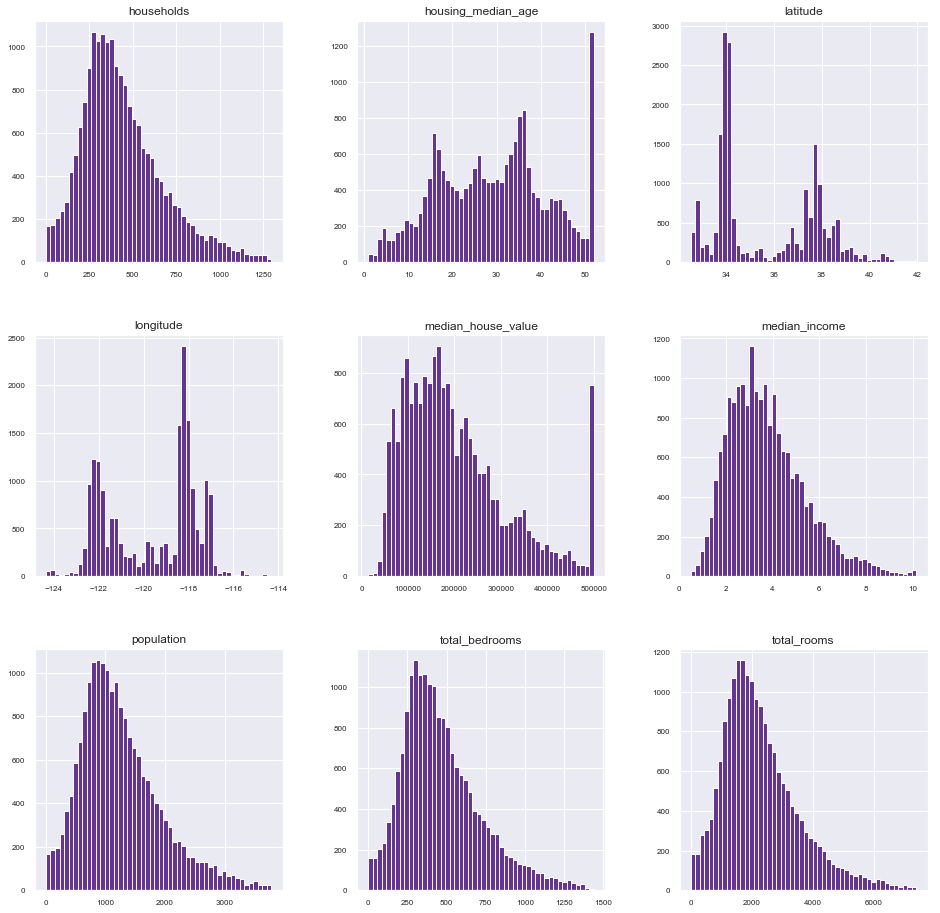

In [25]:
EDA_functions.plot_num_hist(housing)

In [26]:
cleaning_functions.apply_log10(housing)

TypeError: apply_log10() missing 1 required positional argument: 'cols_to_log10'